# MHP demo

Load plotting, numpy, and everything from MHP, and do notebook magic to autoreload if we make changes to MHP.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from MHP import *

In [2]:
%load_ext autoreload
%autoreload 2

Let's start with a single-dimensional process.  We'll create a process with default values and generate a sequence.

In [36]:
P1 = MHP()
seq1 = P1.generate(60)
print(seq1[:5,:])

[[ 0.          0.        ]
 [ 4.31531738  0.        ]
 [11.11606372  0.        ]
 [21.39980894  0.        ]
 [21.52974308  0.        ]]


Plotting the events we see the characteristic clustering of a self-exciting process.

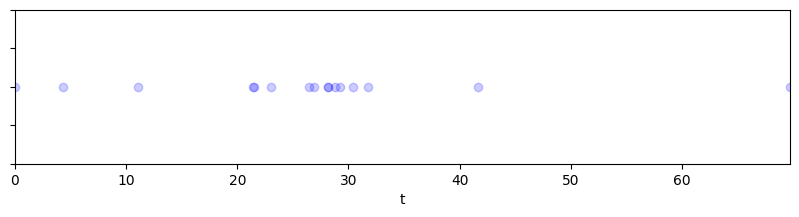

In [37]:
plot_events(seq1)

Plotting the rates atop the point sequence shows the rate spikes and the accumulation that happens in the clusters.

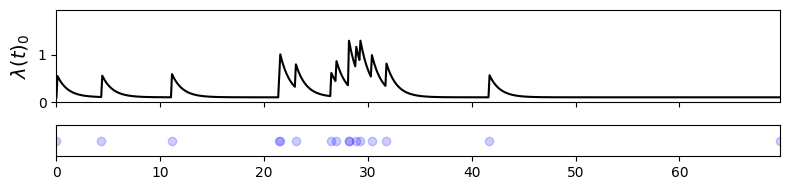

In [38]:
plot_events_and_rates(mhp=P1, data=seq1)

Let's do a more interesting example with 3 dimensions.  We'll setup some demo parameter values for base rate $\mu$, kernel matrix $A$, and decay rate $\omega$, and create a model with these parameters.

In [7]:
m = np.array([0.2, 0.0, 0.0])
a = np.array([[0.1, 0.0, 0.0], 
              [0.9, 0.0, 0.0],
              [0.0, 0.9, 0.0]])
w = 3.1

P = MHP(mu=m, alpha=a, omega=w)

Use the model to generate a sequence and use a built-in visualization function.

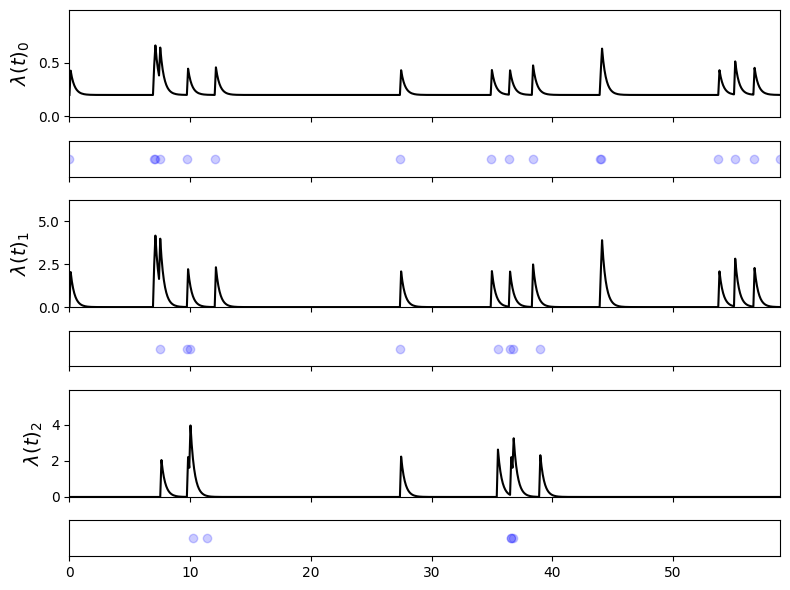

In [8]:
seq = P.generate(60)
plot_events_and_rates(mhp=P, data=seq)

Note we structured this so Process 0 influences itself (self-exciting) and Process 1, which in turn influences Process 2.  We can see these effects borne out in the realization of events.  For example, note events in 0 create spikes on 1, which occasionally also lead to events; similarly from 1 to 2.  Also note that processes 1 and 2 never create spikes for themselves from their own events.

Now we'll use the built-in MAP EM algorithm to estimate these parameters.  (We are using the same object `P` but setting random initial guesses for params, so it is not using the true values.)

In [11]:
mhat = np.random.uniform(0,1, size=3)
ahat = np.random.uniform(0,1, size=(3,3))
w = 3.

Ah, mh, pii, pij = P.train(seq, Ahat=ahat, mhat=mhat, omega=w)

Doing precomputations ... 0.000
Iter 0 (LL: -1.4284488943433509) ... 0.002
Iter 10 (LL: -2.0390966330052676) ... 0.004
Iter 20 (LL: -2.0317389709345473) ... 0.006
Iter 30 (LL: -2.0308961326542385) ... 0.008
Iter 40 (LL: -2.030794277996135) ... 0.009
Iter 50 (LL: -2.030781792932611) ... 0.011
Iter 60 (LL: -2.030780249397425) ... 0.012
Iter 70 (LL: -2.0307800573573216) ... 0.014
Iter 80 (LL: -2.0307800333489143) ... 0.016
Iter 90 (LL: -2.030780030336401) ... 0.020
Reached max iter 100 (LL: -2.030780030336401) ... 0.022


In [20]:
for a in [Ah, mh]:
    with np.printoptions(precision=3, suppress=True):
        print(a)

[[0.    0.    0.   ]
 [0.133 0.    0.028]
 [0.    0.128 0.18 ]]
[0.272 0.    0.   ]


These are already reasonable guesses to the true values, given we only have one small sample (and note we have not introduced regularization).

Because we are using an EM algorithm that estimates the branching structure of the process as a latent variable, we can also use this information to interpret the results.

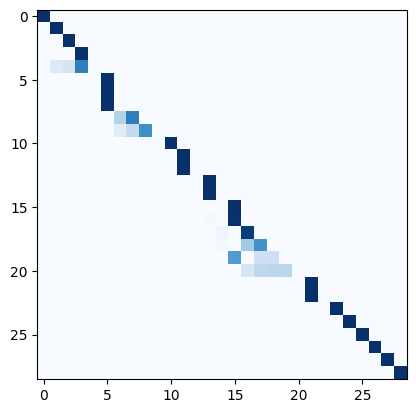

In [17]:
pfull = pij.copy()
pfull[np.diag_indices(pij.shape[0])] = pii
plt.imshow(pfull, cmap='Blues', vmin=0, vmax=1)

Recall this matrix (the estimated latent branching structure) is row-stochastic, with each entry $p_{ij}$ representing the probability that event $i$ was caused by event $j$.  High values along the diagonal indicate self-exciting events.  We see many rows with off-diagonal values, indicating probability of a previous "parent" event causing it.